## Project idea 4:
### implement and test at least 6 different variants of Isomap for DGP: the three above, and at least three new ones of your own conception

In [77]:

import sys
import numpy as np
import math
import types
import matplotlib.pyplot as plt

In [78]:

# The only 3 lines you need to install and use AMPL with any solver on Colab
%pip install -q amplpy
from amplpy import AMPL, ampl_notebook

P = ampl_notebook(
    modules=["highs", "gurobi"],  # modules to install (guroby is the best solver)
    license_uuid="bf5b5ed2-ea35-4373-8776-1ab021939a37",  # license to use
)  # instantiate AMPL object and register magics

Note: you may need to restart the kernel to use updated packages.
Licensed to Bundle #6415.6806 expiring 20240515: INF580 Large-scale optimization, Leo Liberti, LIX Ecole Polytechnique.


### Isomap for DGP


[(0, 1, {'weight': 1}), (0, 2, {'weight': 7}), (0, 3, {'weight': 9}), (0, 4, {'weight': 6}), (0, 7, {'weight': 6}), (1, 2, {'weight': 4}), (1, 4, {'weight': 5}), (1, 5, {'weight': 7}), (1, 9, {'weight': 8}), (2, 5, {'weight': 2}), (2, 7, {'weight': 3}), (2, 8, {'weight': 6}), (3, 7, {'weight': 3}), (4, 5, {'weight': 1}), (4, 6, {'weight': 10}), (4, 9, {'weight': 9}), (5, 9, {'weight': 6}), (6, 7, {'weight': 7}), (6, 8, {'weight': 1}), (7, 8, {'weight': 7})]


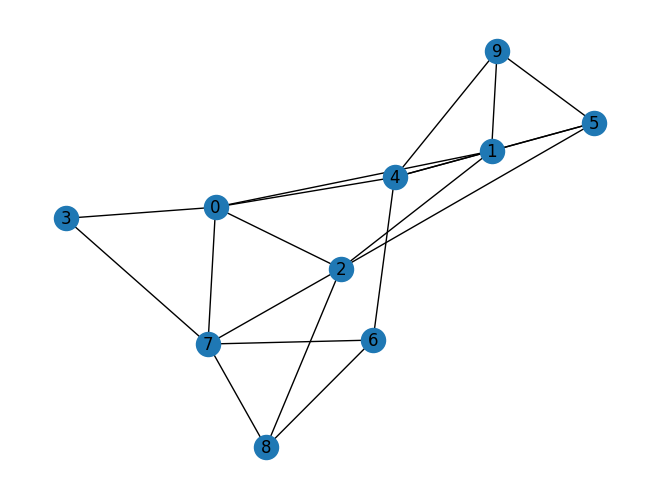

In [79]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def biconnected_graph(n):
   X = nx.gnp_random_graph(n, 0.5, directed=False)
   while(not nx.is_biconnected(X)):
         X = nx.gnp_random_graph(n, 0.5, directed=False)
   for (u, v) in X.edges():
       X[u][v]['weight'] = random.randint(1, 10)
   return X

X = biconnected_graph(10)
print(X.edges(data=True))
nx.draw(X, with_labels=True)

In [80]:

with open('biconnected_graph.dat', 'w') as f:
    f.write("# file generated by clique-instgen.run")
    f.write("\n")
    f.write("param n := %d;\n" % 50)
    f.write("set E :=")
    for (i,j) in X.edges():
        weight=X[i][j]['weight']
        f.write(" (%d,%d)" % (i,j))
    f.write(";\n")
    f.close()


In [81]:
def floyd_warshall(G):
    for i in G.nodes():
        for j in G.nodes():
            if i != j and not G.has_edge(i, j):
                found=False
                for k in G.nodes():
                    if i != k and j != k and G.has_edge(i, k) and G.has_edge(k, j):
                        found=True
                        break
                if not found:
                    return False
    return True
            
print(floyd_warshall(X))

False


In [82]:

myZero = 1e-9

## return the distance matrix of a realization
def distanceMatrix(x, p=2):
    n = len(x[:,0])
    D = np.zeros((n,n))
    for u in range(n-1):
        for v in range(u+1,n):
            D[u,v] = np.linalg.norm(np.subtract(x[u,:],x[v,:]), ord=p)
            D[v,u] = D[u,v]
    return D

## convert a distance matrix to a Gram matrix
def dist2Gram(D):
    n = D.shape[0]
    J = np.identity(n) - (1.0/n)*np.ones((n,n))
    G = -0.5 * np.dot(J,np.dot(np.square(D), J))
    return G

## factor a square matrix
def factor(A):
    n = A.shape[0]
    (evals,evecs) = np.linalg.eigh(A)
    evals[evals < 0] = 0  # closest SDP matrix
    X = evecs #np.transpose(evecs)
    sqrootdiag = np.eye(n)
    for i in range(n):
        sqrootdiag[i,i] = math.sqrt(evals[i])
    X = X.dot(sqrootdiag)
    return np.fliplr(X)

## classic Multidimensional scaling
def MDS(B, eps = myZero):
    n = B.shape[0]
    x = factor(B)
    (evals,evecs) = np.linalg.eigh(x)
    K = len(evals[evals > eps])
    if K < n:
        # only first K columns
        x = x[:,0:K]
    return x

## principal component analysis
def PCA(B, K = "None"):
    x = factor(B)
    n = B.shape[0]
    if isinstance(K, str):
        K = n
    if K < n:
        # only first K columns
        x = x[:,0:K]
    return x

## main

# if len(sys.argv) < 2:
#     exit('need .uie file in input')

# # read input file
# lines = [line.rstrip('\n').split()[2:] for line in open(sys.argv[1]) if line[0] == 'x']
# n = len(lines)

# turn into float array
# X = np.array([[float(lines[i][j]) for j in range(n)] for i in range(n)])



In [83]:
# make distance matrix
#D = distanceMatrix(X) # Euclidean distance

D= nx.to_numpy_array(X)
 # if using UIE, realization = DM
# derive Gram matrix

G = dist2Gram(D)

x = MDS(G)
n = x.shape[0]
K = x.shape[1]
print("dimension can be reduced from", n, "to", K)




dimension can be reduced from 10 to 5


In [84]:
# PCA
if K > 3:
    K = 3
elif K < 2:
    K = 2
print("representing in", K, "dimensions")

x = PCA(G,K)
    
if K == 2:
    plt.scatter(x[:,0], x[:,1])
elif K == 3:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(x[:,0], x[:,1], x[:,2])
    ax.plot(x[:,0], x[:,1], x[:,2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
plt.show()